In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 




import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.bert_conf
encoding_type = 'brk'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_bert_about_brk'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.49362244897959184
MALE 0.9921875
FEMALE 0.015 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5151515151515151
MALE 0.9854014598540146
FEMALE 0.007874015748031496 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5267275097783573
MALE 0.9974747474747475
FEMALE 0.02425876010781671 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6813032668642051 	 Validation loss: 0.6784954919653424 	 
  1%|          | 574/57400 [01:30<2:14:54,  7.02it/s]
Epoch 2 	 Training loss: 0.6716555547008116 	 Validation loss: 0.6649419099597608 	 
  2%|▏         | 1148/57400 [02:55<2:06:16,  7.42it/s]
Epoch 3 	 Training loss: 0.6498463431094166 	 Validation loss: 0.6258309089531333 	 
  3%|▎         | 1722/57400 [04:21<2:12:54,  6.98it/s]
Epoch 4 	 Training loss: 0.5834268691336236 	 Validation loss: 0.526428418644404 	 
  4%|▍         | 2296/57400 [05:47<2:00:36,  7.61it/s]
Epoch 5 	 Training loss: 0.4892965083753606 	 Validation loss: 0.44445458862741116 	 
  5%|▌         | 2870/57400 [07:13<2:14:14,  6.77it/s]
Epoch 6 	 Training loss: 0.4318097951312514 	 Validation loss: 0.4031022706274259 	 
  6%|▌         | 3444/57400 [08:39<1:48:46,  8.27it/s]
Epoch 7 	 Training loss: 0.40248912069232623 	 Validation loss: 0.3796283572407092 	 
  7%|▋         | 4018/57400 [10:05<1:53:52,  7.81it/s]
Epoch 8 	 Training l

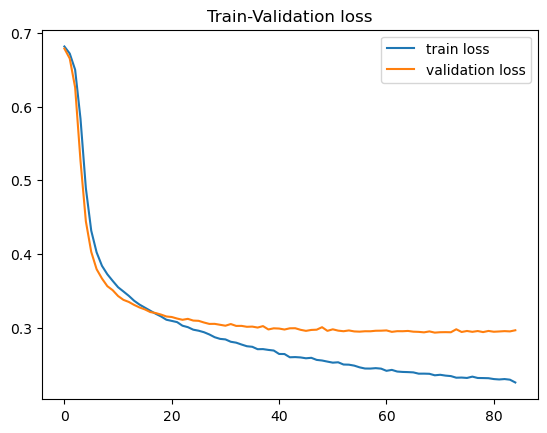

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8558673469387755
MALE 0.8671875
FEMALE 0.845 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6818181818181818
MALE 0.6885644768856448
FEMALE 0.6745406824146981 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.681877444589309
MALE 0.696969696969697
FEMALE 0.6657681940700808 



# TO

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_bert_to_brk'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6958340546602987 	 Validation loss: 0.6932706085302062 	 
  1%|          | 574/57400 [01:24<2:17:37,  6.88it/s]
Epoch 2 	 Training loss: 0.6945391245419971 	 Validation loss: 0.693907716516721 	 
  2%|▏         | 1148/57400 [02:48<2:14:21,  6.98it/s]
Epoch 3 	 Training loss: 0.6941380978461342 	 Validation loss: 0.69294051800744 	 
  3%|▎         | 1722/57400 [04:13<2:08:50,  7.20it/s]
Epoch 4 	 Training loss: 0.6942742173056985 	 Validation loss: 0.6944654371778843 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [05:37<2:17:48,  6.66it/s]
Epoch 5 	 Training loss: 0.6941698198742152 	 Validation loss: 0.6935698905233609 	 
  5%|▌         | 2870/57400 [07:01<2:14:12,  6.77it/s]
Epoch 6 	 Training loss: 0.694261377385269 	 Validation loss: 0.6930846733562017 	 
  6%|▌         | 3444/57400 [08:25<1:55:49,  7.76it/s]
Epoch 7 	 Training loss: 0.6939340485097639 	 Validation loss: 0.6930385434021384 	 
  7%|▋         | 4018/57400 [09:49<2:03:06,  7.23it

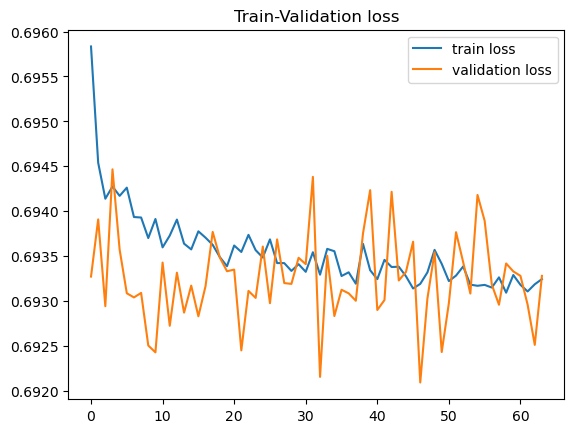

In [20]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.4744897959183674
MALE 0.2265625
FEMALE 0.7125 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.49873737373737376
MALE 0.24817518248175183
FEMALE 0.7690288713910761 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5202086049543677
MALE 0.29545454545454547
FEMALE 0.7601078167115903 



# AS

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_bert_as_brk'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6952989284169798 	 Validation loss: 0.6946648419913599 	 
  1%|          | 574/57400 [01:34<3:00:33,  5.25it/s]
Epoch 2 	 Training loss: 0.6945307386669133 	 Validation loss: 0.6941697132789483 	 
  2%|▏         | 1148/57400 [03:18<2:28:19,  6.32it/s]
Epoch 3 	 Training loss: 0.6945906605454687 	 Validation loss: 0.6938778404462136 	 
  3%|▎         | 1722/57400 [04:45<1:49:39,  8.46it/s]
Epoch 4 	 Training loss: 0.6944457258289284 	 Validation loss: 0.693402610592923 	 
  4%|▍         | 2296/57400 [06:11<2:00:02,  7.65it/s]
Epoch 5 	 Training loss: 0.6939637294422043 	 Validation loss: 0.6931713587146694 	 
  5%|▌         | 2870/57400 [07:37<1:50:22,  8.23it/s]
Epoch 6 	 Training loss: 0.6935347234538208 	 Validation loss: 0.6924031881962792 	 
  6%|▌         | 3444/57400 [09:02<2:12:14,  6.80it/s]
Epoch 7 	 Training loss: 0.6935602704822394 	 Validation loss: 0.6927029985492512 	 
  7%|▋         | 4018/57400 [10:31<2:07:22,  6.98it/s]
Epoch 8 	 Training los

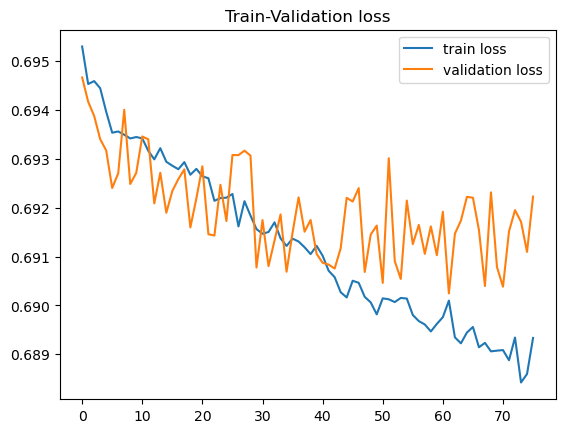

In [16]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [18]:
save_path='m1_dep_bert_as_brk'
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.7423469387755102
MALE 0.6354166666666666
FEMALE 0.845 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6830808080808081
MALE 0.6058394160583942
FEMALE 0.7664041994750657 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6714471968709257
MALE 0.5454545454545454
FEMALE 0.8059299191374663 

